In [6]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('../data/PRSA_data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('../data/pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


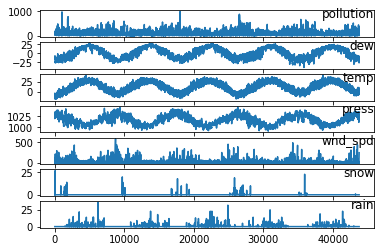

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('../data/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [ ]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
data_file = '../data/pollution.csv'
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [7]:
# load dataset
dataset = read_csv(data_file, header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [8]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 2
train = values[:n_train_hours, :]
val = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(17520, 1, 8) (17520,) (26279, 1, 8) (26279,)


In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [12]:
default_optimizer = keras.optimizers.Adagrad(lr=1e-4, epsilon=None, decay=0.0)

dropout = 0.75
nb_out = 1

# design network
model = Sequential()
model.add(LSTM(units = 1024, 
               input_shape=(train_X.shape[1], train_X.shape[2]),
               return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(units=256,
               return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(units=256,
               return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(units=64,
               return_sequences=False))
model.add(Dropout(dropout))
model.add(Dense(units=nb_out, 
                activation='elu' #'sigmoid'
               ))
model.compile(loss='mae', # 'binary_crossentropy'
              optimizer=default_optimizer, 
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 1024)           4231168   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1024)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            1311744   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 256)            525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                82176     
__________

In [15]:
import os
model_path = '../model/multivariate_LSTM.h5'
if os.path.exists(model_path):
    model.load_weights(model_path)

In [ ]:
# fit network
history = model.fit(train_X, train_y, 
                    epochs=50, 
                    batch_size=72, 
                    validation_data=(val_X, 
                                     val_y), 
                    verbose=2, 
                    shuffle=False,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                               min_delta=0, 
                                                               patience=10, 
                                                               verbose=0, 
                                                               mode='min'),
                                 keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                                 save_best_only=True, 
                                                                 mode='min', 
                                                                 verbose=0)])

Train on 17520 samples, validate on 26279 samples
Epoch 1/50
 - 73s - loss: 0.9353 - acc: 2.8539e-04 - val_loss: 0.9157 - val_acc: 2.6637e-04
Epoch 2/50
 - 70s - loss: 0.8962 - acc: 3.9954e-04 - val_loss: 0.8832 - val_acc: 4.9469e-04
Epoch 3/50
 - 69s - loss: 0.8665 - acc: 5.1370e-04 - val_loss: 0.8545 - val_acc: 5.3274e-04
Epoch 4/50
 - 71s - loss: 0.8401 - acc: 6.2785e-04 - val_loss: 0.8270 - val_acc: 6.0885e-04
Epoch 5/50
 - 73s - loss: 0.8130 - acc: 6.2785e-04 - val_loss: 0.7989 - val_acc: 6.4690e-04
Epoch 6/50
 - 72s - loss: 0.7869 - acc: 6.2785e-04 - val_loss: 0.7701 - val_acc: 7.6106e-04
Epoch 7/50
 - 72s - loss: 0.7591 - acc: 8.5616e-04 - val_loss: 0.7401 - val_acc: 8.3717e-04
Epoch 8/50
 - 73s - loss: 0.7318 - acc: 0.0011 - val_loss: 0.7086 - val_acc: 0.0011
Epoch 9/50
 - 72s - loss: 0.7039 - acc: 0.0014 - val_loss: 0.6756 - val_acc: 0.0014
Epoch 10/50
 - 71s - loss: 0.6768 - acc: 0.0014 - val_loss: 0.6415 - val_acc: 0.0016
Epoch 11/50
 - 72s - loss: 0.6486 - acc: 0.0018 - val

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(val_X)
test_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, val_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, val_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)